In [ ]:
# GEOSPATIAL SCORING AGGREGATION AND MAPPING
# Version: 1.0
# Author: Perez Joan
# This script aggregates individual image-based scores (e.g., from LLaVA) and
# merges them with OpenStreetMap (OSM) geospatial data in a GeoPackage format.
# Each image is assumed to be named according to a structured convention
# (e.g., point_12_180.jpg) where each physical point may have up to four
# directional views (0°, 90°, 180°, 270°). Scores associated with these images
# are averaged per point, and then further aggregated to the street level using
# their spatial links. The result is a clear, multi-scale geospatial
# interpretation: you can visualize how different streets or areas score based
# on image-level observations. The script also generates two maps (point
# scores and street averages)and writes updated data back to a GeoPackage.

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import shutil
import os
from google.colab import drive

# ------------------------ USER PARAMETERS -------------------------------------
drive.mount('/content/drive')

# 🔧 Define the name of the case study (e.g., 'nice', 'vienna')
case_study_name = 'nice'

# 👉 Choose the task (e.g., 'T1', 'T2', or 'T3')
task_version = 'T2'

# 👉 Aggregation mode for the maps: choose either 'average' or 'sum'
aggregation_mode = 'sum'

# ------------------------ FOLDERS STRUCTURE ------------------------

# Construct all necessary paths automatically
base_dir = f'/content/drive/MyDrive/SAGAI'
csv_path = f'{base_dir}/Image_Analysis/Score_Analysis_LLaVA_{case_study_name.capitalize()}_{task_version}.csv'
gpkg_path = f'{base_dir}/StreetSamples/{case_study_name}_osm.gpkg'
output_gpkg_path = f'{base_dir}/Spatial_Results/{case_study_name}_osm_joined_{task_version}.gpkg'
os.makedirs(os.path.dirname(output_gpkg_path), exist_ok=True)

# GeoPackage layers
points_layer = 'points'
streets_layer = 'streets'

Mounted at /content/drive


In [ ]:
# ------------------------- PROCESSING -------------------------
# Load layers
points_gdf = gpd.read_file(gpkg_path, layer=points_layer)
streets_gdf = gpd.read_file(gpkg_path, layer=streets_layer)
scores_df = pd.read_csv(csv_path)

# Extract base_id (e.g., point_12_180.jpg → point_12)
scores_df['base_id'] = scores_df['image_name'].apply(lambda x: "_".join(x.split('_')[:2]))
scores_df['score'] = pd.to_numeric(scores_df['score'].replace("NA", pd.NA), errors='coerce')

# Ensure all point_ids are preserved, even if no score
all_base_ids = points_gdf[['point_id']].rename(columns={'point_id': 'base_id'})
merged_scores = all_base_ids.merge(scores_df[['base_id', 'score']], on='base_id', how='left')

# Compute all aggregation stats at the point level
point_stats = merged_scores.groupby('base_id', dropna=False)['score'].agg(
    mean='mean',
    sum='sum',
    median='median',
    var='var'
).reset_index()
points_gdf = points_gdf.merge(point_stats, left_on='point_id', right_on='base_id', how='left')
points_gdf.drop(columns='base_id', inplace=True)

# Compute all aggregation stats at the street level
valid_points = points_gdf[points_gdf['mean'].notna()]
street_stats = valid_points.groupby('street_id').agg(
    average_overall_score=('mean', 'mean'),
    total_score=('sum', 'sum'),
    median_score=('median', 'mean'),
    variance_score=('var', 'mean')
).reset_index()
streets_gdf = streets_gdf.merge(street_stats, on='street_id', how='left')

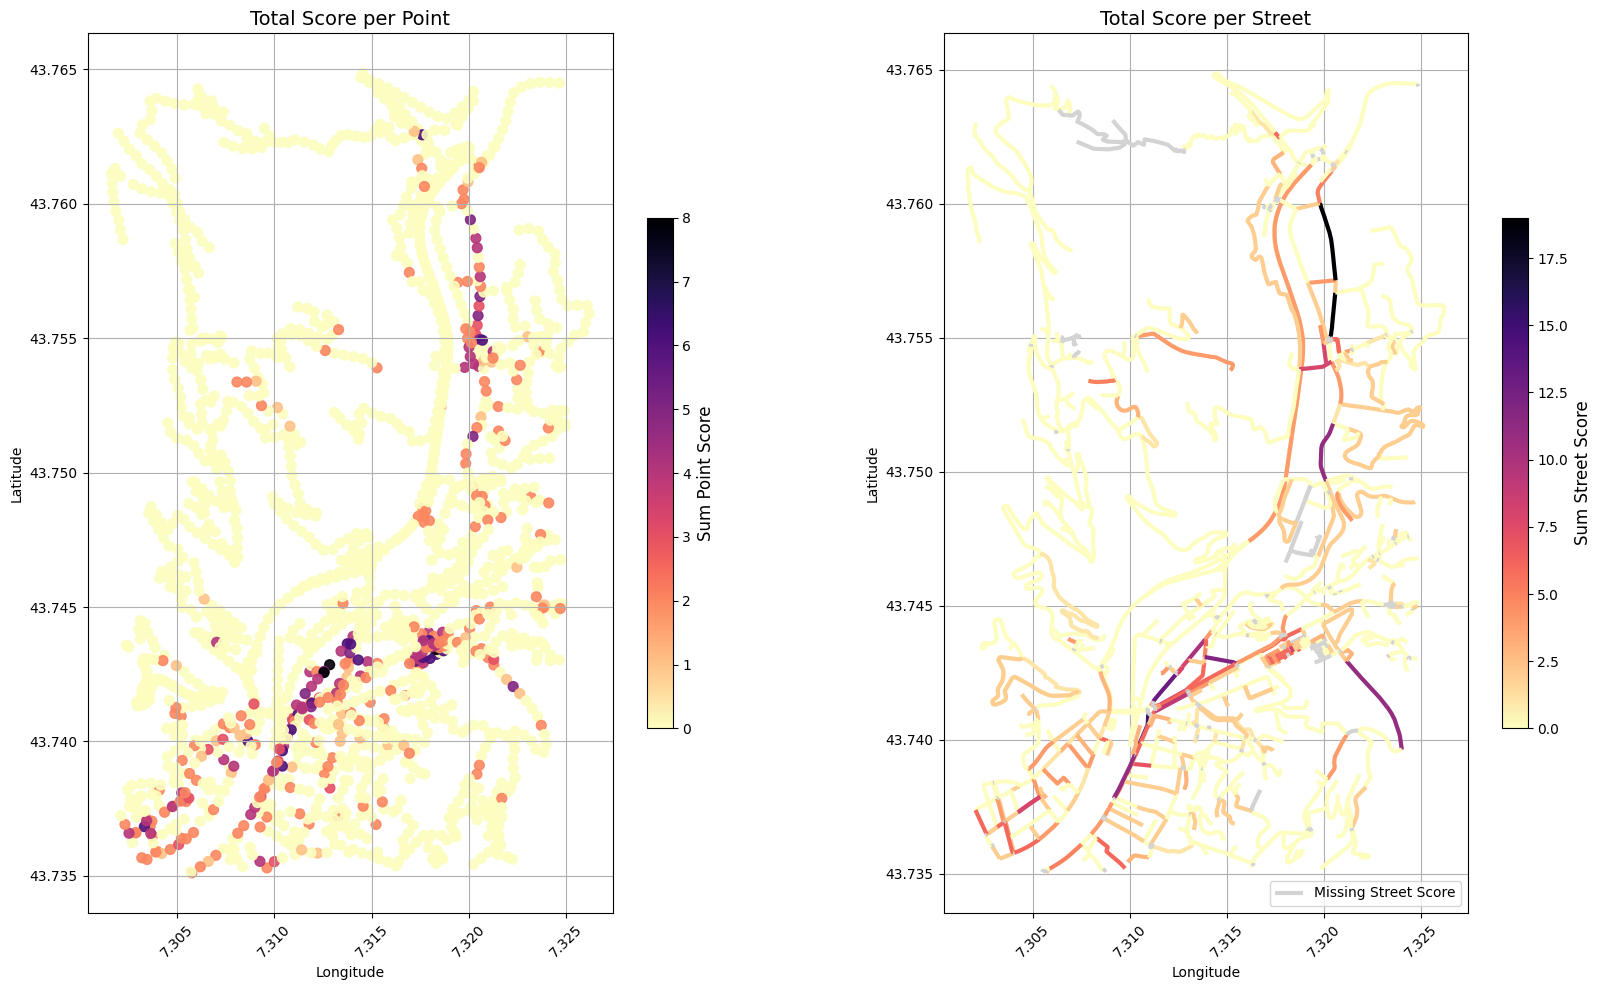

In [ ]:
# ------------------------- VISUALIZATION -------------------------

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
cmap = 'magma_r'
vmin = 0

# Map 1: Points
points_ax = axes[0]
points_gdf = points_gdf.to_crs("EPSG:4326")

if aggregation_mode == 'average':
    score_col = 'mean'
    title1 = 'Average Score per Point'
    cbar_label1 = 'Mean Point Score'
    valid = points_gdf[points_gdf[score_col].notna()]
    missing = points_gdf[points_gdf[score_col].isna()]
    vmax = 1
elif aggregation_mode == 'sum':
    score_col = 'sum'
    title1 = 'Total Score per Point'
    cbar_label1 = 'Sum Point Score'
    valid = points_gdf[points_gdf[score_col].notna()]
    missing = points_gdf[points_gdf[score_col].isna()]
    vmax = valid[score_col].max()

valid.plot(
    ax=points_ax,
    column=score_col,
    cmap=cmap,
    markersize=50,
    legend=False,
    vmin=vmin,
    vmax=vmax,
    alpha=0.9
)

if not missing.empty:
    missing.plot(
        ax=points_ax,
        color='lightgrey',
        markersize=50,
        label='Missing Point Score'
    )

points_ax.set_title(title1, fontsize=14)
points_ax.set_xlabel('Longitude')
points_ax.set_ylabel('Latitude')
points_ax.tick_params(axis='x', rotation=45)
points_ax.grid(True)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=points_ax, fraction=0.03, pad=0.04)
cbar.set_label(cbar_label1, fontsize=12)

if not missing.empty:
    points_ax.legend(loc='lower right', fontsize=10, frameon=True)

# Map 2: Streets
streets_ax = axes[1]
streets_gdf = streets_gdf.to_crs("EPSG:4326")

if aggregation_mode == 'average':
    street_col = 'average_overall_score'
    title2 = 'Average Score per Street'
    cbar_label2 = 'Mean Street Score'
    valid_streets = streets_gdf[streets_gdf[street_col].notna()]
    nan_streets = streets_gdf[streets_gdf[street_col].isna()]
    vmax = 1
elif aggregation_mode == 'sum':
    street_col = 'total_score'
    title2 = 'Total Score per Street'
    cbar_label2 = 'Sum Street Score'
    valid_streets = streets_gdf[streets_gdf[street_col].notna()]
    nan_streets = streets_gdf[streets_gdf[street_col].isna()]
    vmax = valid_streets[street_col].max()

valid_streets.plot(
    ax=streets_ax,
    column=street_col,
    cmap=cmap,
    linewidth=3,
    legend=False,
    vmin=vmin,
    vmax=vmax
)

if not nan_streets.empty:
    nan_streets.plot(
        ax=streets_ax,
        color='lightgrey',
        linewidth=3,
        label='Missing Street Score'
    )

streets_ax.set_title(title2, fontsize=14)
streets_ax.set_xlabel('Longitude')
streets_ax.set_ylabel('Latitude')
streets_ax.tick_params(axis='x', rotation=45)
streets_ax.grid(True)

sm2 = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=streets_ax, fraction=0.03, pad=0.04)
cbar2.set_label(cbar_label2, fontsize=12)

if not nan_streets.empty:
    streets_ax.legend(loc='lower right', fontsize=10, frameon=True)

plt.tight_layout()
plt.show()


In [ ]:
# ------------------------- SAVE RESULT IN NEW GPKG -------------------------

# Save updated points layer
points_gdf.to_file(output_gpkg_path, layer=points_layer, driver='GPKG')

# Save updated streets layer
streets_gdf.to_file(output_gpkg_path, layer=streets_layer, driver='GPKG')

print(f"📁 Saved updated data to: {output_gpkg_path}")

📁 Saved updated data to: /content/drive/MyDrive/SAGAI/Spatial_Results/nice_osm_joined_T2.gpkg
